In [1]:
import os
import re
import gzip
import nibabel as nib
from PIL import Image
import cv2
import pydicom

import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pdb

from CompositionalNets.Code.config import vc_num
from CompositionalNets.Initialization_Code.comptSimMat import compute_similarity_matrix
from CompositionalNets.Initialization_Code.vMF_clustering import learn_vmf_clusters, save_cluster_images
from CompositionalNets.Initialization_Code.Learn_mix_model_vMF_view import learn_mix_model_vMF
from CompositionalNets.Initialization_Code.config_initialization import nn_type

from src.config import Directories
from src.models import UNet
from src.dataset import ClassificationDataset, apply_ct_abdomen_filter, get_chaos_volumes, TripleDataset
from src.utils import synthetic_occlusion

%load_ext autoreload
%autoreload 2
torch.manual_seed(42)

max_images 5000


In [2]:
%%time
tight_crop = True

# TODO make this faster by reading slices from h5py instead of directly
# slicing from the volume
# vol_dir = os.path.join(Directories.CHAOS_REGISTRATIONS, 'affine', 'out')
vol_dir = os.path.join(Directories.CHAOS_REGISTRATIONS, 'affine')
regex = re.compile('.*\.nii\.gz')
names = [f for f in sorted(os.listdir(vol_dir)) if regex.match(f)]
slices = []
slice_range = (-4, 4)
volume_filepaths = get_chaos_volumes(Directories.CHAOS)

# use_masks = 'out' not in vol_dir
masks = []
use_masks = False
# all_masks = []

for i, name in enumerate(names):
    
    pairs = volume_filepaths[i]
    fp = os.path.join(vol_dir, name)
    
    with gzip.open(fp, 'rb') as f:

        niftii_object = nib.load(f.filename)
        volume = np.array(niftii_object.dataobj, dtype=np.int16)
        
        num_slices = volume.shape[2]
        amount = np.zeros(num_slices)
        
        assert num_slices == len(pairs)
        
        for j in range(num_slices):

            s = volume[...,j]
            background = s.min()
            amount[j] = np.sum(s==background)
        
        idx = np.argmin(amount)
#         idx = 60
        
        if use_masks:
            for k in range(idx+slice_range[0], idx+slice_range[1]):
                _, mask_fp = pairs[k]
                mask = np.array(Image.open(mask_fp), dtype=np.uint8)
                masks.append(mask)

        curr_slices = volume[..., idx+slice_range[0]:idx+slice_range[1]]
        
        curr_slices = apply_ct_abdomen_filter(curr_slices)

        curr_min, curr_max = curr_slices.min(), curr_slices.max()
        curr_slices = (curr_slices - curr_min) / (curr_max - curr_min + 1e-12)

        curr_slices = np.transpose(curr_slices, (2, 0, 1))
        curr_slices = np.stack((curr_slices, curr_slices, curr_slices), axis=len(curr_slices.shape))
        curr_slices = np.rot90(curr_slices, k=1, axes=(1,2))
        curr_slices = curr_slices.astype(np.float32)
        
        # Crop around liver
        if tight_crop:
            curr_slices = [img[np.ix_((img[...,0]>0).any(1), (img[...,0]>0).any(0))] for img in curr_slices]
        
        slices.extend(curr_slices)
        
slices = np.asarray(slices)
if use_masks:
    train_slices, test_slices, train_masks, test_masks = train_test_split(slices, masks, test_size=0.2, random_state=42)
    dataset = TripleDataset(train_slices, train_masks, [0] * len(train_slices), X_transform=transforms.ToTensor())
else:
    train_slices, test_slices = train_test_split(slices, test_size=0.2, random_state=42)
    dataset = ClassificationDataset(train_slices, [0] * len(train_slices), input_transform=transforms.ToTensor())
    
data_loader = DataLoader(dataset, batch_size=1)

synthetic_images = synthetic_occlusion(test_slices[:20], textured=False, color=0.78431374)
for i in range(8):
    try:
        im = Image.open(os.path.join(Directories.DATA, 'tumors', f'tumor_slice{i}.jpg'))
        im = (np.array(im).astype(np.float32) / 255)
        synthetic_images[i] = im
    except Exception as e:
        print(f'{e}')

/home/mattlk/.virtualenvs/CompNet/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: use the name attribute


CPU times: user 10.2 s, sys: 1.47 s, total: 11.7 s
Wall time: 13.3 s


# Clustering

In [ ]:
for kappa in range(60, 61, 10):
    experiment = 32
    kappas = [kappa]
    vmf, loc_set =  learn_vmf_clusters(data_loader, img_per_cat=len(dataset), verbose=True,
                                       max_it=1000, tol=5e-12,
                                       u_out_name=f'chaos_pool5_{vc_num}_u_test_{experiment}.pickle',
                                       p_out_name=f'chaos_pool5_{vc_num}_p_test_{experiment}.pickle',
                                       kappas=kappas)
    save_cluster_images(vmf, loc_set, in_images=train_slices*255,
                    num_images=16, out_dir_name=f'test_{experiment}_{kappa}',
                    max_num_clusters=30)

In [3]:
experiment = 44
vmf, loc_set =  learn_vmf_clusters(data_loader, img_per_cat=len(dataset), verbose=True,
                                   max_it=1000, tol=5e-12,
                                   u_out_name=f'chaos_pool5_{vc_num}_u_test_{experiment}.pickle',
                                   p_out_name=f'chaos_pool5_{vc_num}_p_test_{experiment}.pickle',
                                   kappas=range(30, 31, 5))

Best Kappa: 30. Lowest Similarity: 0.5464333914472249


In [11]:
sort_idx = np.argsort(-vmf.p[:, 1])[0:16]
print(sort_idx)
print(np.sort(-vmf.p[:, 1])[0:16])
differences = [a - b for a,b in zip(np.sort(-vmf.p[:, 1])[0:16], np.sort(-vmf.p[:, 1])[1:17])]
plt.plot(differences)

array([  606, 10239,  2985,  7126,  2988,  2990,  2991,  2992,  2993,
        7124,  2995,  2996,  7123,  7122,  2984,  2999])

In [4]:
save_cluster_images(vmf, loc_set, in_images=train_slices*255,
                    num_images=16, out_dir_name=f'test_{experiment}',
                    max_num_clusters=20)

Saving top 16 images for each cluster


In [48]:
%%time
mat1, mat2 = compute_similarity_matrix(data_loader, 0, f'test_{experiment}',
                                       sim_dir_name=f'similarity_{nn_type}_pool5_chaos_{experiment}',
                                       u_out_name=f'chaos_pool5_{vc_num}_u_test_{experiment}.pickle',
                                       N_sub=min(200, len(dataset)//10), num_layer_features=min(100, len(dataset)))

Determine best threshold for binarization - 0 ...
Start compute sim matrix ... magicThresh 0.2
iter 1/11 1/11
comptSimMat iter time: 2.1979846239089964
iter 1/11 2/11
comptSimMat iter time: 5.057911741733551
iter 1/11 3/11
comptSimMat iter time: 4.97553645769755
iter 1/11 4/11
comptSimMat iter time: 5.277937312920888
iter 1/11 5/11
comptSimMat iter time: 4.999354366461436
iter 1/11 6/11
comptSimMat iter time: 5.072174513339997
iter 1/11 7/11
comptSimMat iter time: 5.590563261508942
iter 1/11 8/11
comptSimMat iter time: 5.032910494009654
iter 1/11 9/11
comptSimMat iter time: 4.248244349161784
iter 1/11 10/11
comptSimMat iter time: 4.9590752998987835
iter 1/11 11/11
comptSimMat iter time: 3.6753109216690065
iter 2/11 2/11
comptSimMat iter time: 2.131492527325948
iter 2/11 3/11
comptSimMat iter time: 4.572820587952932
iter 2/11 4/11
comptSimMat iter time: 5.368749713897705
iter 2/11 5/11
comptSimMat iter time: 4.526493740081787
iter 2/11 6/11
comptSimMat iter time: 4.725780725479126
iter 

In [4]:
learn_mix_model_vMF(data_loader, 0, sim_matrix_name=f'test_{experiment}',
                    num_layers=1, num_clusters_per_layer=1,
                    sim_dir_name=f'similarity_{nn_type}_pool5_chaos_{experiment}',
                    dict_filename=f'chaos_pool5_{vc_num}_u_test_{experiment}.pickle',
                    mixdir_name=f'mix_model_vmf_chaos_EM_all_test_{experiment}/',
                    im_channels=3)

total number of instances for obj 0: 128
16 394 278
Clustering layer 0 ...
0 0 128 0
cluster 0 has 128 samples

ML Step 0 / 10
0
100
cluster 0 has 128 samples
0 changed assignments


# Localize Occluders on Synthetic

In [6]:
import cv2
from CompositionalNets.Code.config import categories, device_ids, categories_train, mix_model_path, dict_dir, layer, vMF_kappa, compnet_type, num_mixtures
from CompositionalNets.Code.config import config as cfg
from CompositionalNets.Code.model import Net
from CompositionalNets.Code.helpers import getVmfKernels, getCompositionModel
from CompositionalNets.Code.eval_occlusion_localization import visualize_response_map, eval_occ_detection
from CompositionalNets.Initialization_Code.config_initialization import extractor

In [7]:
encoder = 'unet'
num_clusters = 16
experiment = 39
occ_likely = [0.6 for _ in range(len(categories_train))]

dict_dir = os.path.join(Directories.COMPOSITIONAL_NETS,
                        f'models/init_{encoder}/dictionary_{encoder}/chaos_pool5_{num_clusters}_u_test_{experiment}.pickle')
weights = getVmfKernels(dict_dir, device_ids)
mix_model_path = os.path.join(Directories.COMPOSITIONAL_NETS, 
                             f'models/init_{encoder}/mix_model_vmf_chaos_EM_all_test_{experiment}/')
mix_models = getCompositionModel(device_ids, mix_model_path, layer,
                                 [0],
                                 compnet_type=compnet_type,
                                 num_mixtures=num_mixtures)

model = Net(extractor, weights, vMF_kappa, occ_likely, mix_models,
            bool_mixture_bg=True,
            compnet_type=compnet_type, num_mixtures=num_mixtures, 
            vc_thresholds=cfg.MODEL.VC_THRESHOLD, occlusion_threshold=22)
if device_ids:
    model.to(device_ids[0])

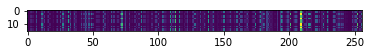

In [15]:
plt.imshow(model.conv1o1.weight.squeeze().detach().cpu().numpy())

In [16]:
weights = model.conv1o1.weight.squeeze().detach().cpu().numpy()

In [12]:
model.conv1o1.weight.squeeze()

torch.Size([16, 256])

In [11]:
deconvs = deconvs.squeeze()
deconvs = deconvs.permute(1, 2, 0)

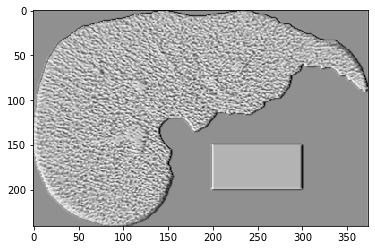

In [16]:
plt.imshow(deconvs[...,-1].cpu().numpy(), cmap="gray")

In [ ]:
cc = transforms.Compose([
    transforms.ToTensor(),
])

i = 0
out_dir = f'{Directories.COMPOSITIONAL_NETS}/models/init_{encoder}/occlusion_maps/test_{experiment}/'
for image in synthetic_images[:]:
    
    if tight_crop:
        image = image[np.ix_((image[...,0]>0).any(1), (image[...,0]>0).any(0))]
    image = cc(image)

    if device_ids:
        image = image.cuda(device_ids[0])

    image = image.unsqueeze(0)
    try:
        with torch.no_grad():
            score, occ_maps, part_scores = model.get_occlusion(image, 0)
            deconvs = model.vc_activation_deconv(image)

        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='', cbarmax=0)

        img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
        faco = img_orig.shape[0] / occ_img.shape[0]

        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))[:,:img_orig.shape[1],:]

        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        plt.figure(figsize=(7, 7))
        plt.imshow(canvas)
        plt.axis('off')
        
    except Exception as e:
        print(e)

In [ ]:
cc = transforms.Compose([
    transforms.ToTensor(),
])

i = 0
out_dir = f'{Directories.COMPOSITIONAL_NETS}/models/init_{encoder}/occlusion_maps/test_{experiment}/'
for image in synthetic_images[:]:
    
    if tight_crop:
        image = image[np.ix_((image[...,0]>0).any(1), (image[...,0]>0).any(0))]
    image = cc(image)

    if device_ids:
        image = image.cuda(device_ids[0])

    image = image.unsqueeze(0)
    try:
        with torch.no_grad():
            score, occ_maps, part_scores = model.get_occlusion(image, 0)
            deconvs = model.vc_activation_deconv(image)

        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='', cbarmax=0)

        img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
        faco = img_orig.shape[0] / occ_img.shape[0]

        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))[:,:img_orig.shape[1],:]

        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        plt.figure(figsize=(7, 7))
        plt.imshow(canvas)
        plt.axis('off')
    except Exception as e:
        print(e)

> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  n


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(300)clutter_likelihood()
-> num_clutter_models = self.clutter_model.shape[0]


(Pdb)  n


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(302)clutter_likelihood()
-> k = F.normalize(torch.clamp(self.clutter_model, 0, 1), p=1, dim=1)


(Pdb)  n


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(307)clutter_likelihood()
-> k = k.unsqueeze(2).repeat(


(Pdb)  k


tensor([[0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]],
       device='cuda:0')


(Pdb)  k.shape


torch.Size([1, 16])


(Pdb)  n


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(308)clutter_likelihood()
-> 1, 1, hx * wx).reshape([k.shape[0], cx, hx, wx])


(Pdb)  n


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(309)clutter_likelihood()
-> occ_likely = self.occ_likely[0]


(Pdb)  k.shape


torch.Size([1, 16, 32, 42])


(Pdb)  k


tensor([[[[0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          ...,
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625]],

         [[0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          ...,
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625]],

         [[0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          [0.0625, 0.0625, 0.0625,  ..., 0

(Pdb)  k.unique()


tensor([0.0625], device='cuda:0')


(Pdb)  l


304  	            k = self.clutter_model
305  	
306  	        # .type(torch.cuda.HalfTensor)
307  	        k = k.unsqueeze(2).repeat(
308  	            1, 1, hx * wx).reshape([k.shape[0], cx, hx, wx])
309  ->	        occ_likely = self.occ_likely[0]
310  	
311  	        if self.compnet_type == 'vmf':
312  	            bg = (v * k).sum(1)
313  	            background = torch.log(bg * occ_likely + 1e-10)
314  	            mm = F.normalize(torch.clamp(self.mix_model, 0, 1), p=1, dim=1)


(Pdb)  n


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(311)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(312)clutter_likelihood()
-> bg = (v * k).sum(1)


(Pdb)  


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(313)clutter_likelihood()
-> background = torch.log(bg * occ_likely + 1e-10)


(Pdb)  bg


tensor([[[2.4436e+09, 1.4145e+11, 1.2926e+11,  ..., 7.5531e+09,
          9.7073e+10, 5.1346e+09],
         [1.7643e+11, 2.8540e+12, 2.7597e+12,  ..., 1.0544e+08,
          4.8273e+09, 1.7852e+10],
         [1.5736e+11, 2.8309e+12, 2.7170e+12,  ..., 5.5781e+03,
          5.0300e+05, 5.0821e+07],
         ...,
         [1.5736e+11, 2.8484e+12, 1.3980e+12,  ..., 2.7170e+12,
          2.5885e+12, 3.0184e+11],
         [1.7014e+11, 2.6016e+12, 2.6308e+12,  ..., 2.6205e+12,
          2.4572e+12, 2.5570e+11],
         [3.0343e+09, 2.5343e+11, 2.2835e+11,  ..., 2.2835e+11,
          2.6891e+11, 9.2174e+09]]], device='cuda:0')


(Pdb)  l


308  	            1, 1, hx * wx).reshape([k.shape[0], cx, hx, wx])
309  	        occ_likely = self.occ_likely[0]
310  	
311  	        if self.compnet_type == 'vmf':
312  	            bg = (v * k).sum(1)
313  ->	            background = torch.log(bg * occ_likely + 1e-10)
314  	            mm = F.normalize(torch.clamp(self.mix_model, 0, 1), p=1, dim=1)
315  	        elif self.compnet_type == 'bernoulli':
316  	            background = (v * torch.log(k + 1e-3) + (1.0 - v) *
317  	                          torch.log(1-(k + 1e-3))).sum(1) + np.log(occ_likely)
318  	            mm = self.mix_model


(Pdb)  n


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(314)clutter_likelihood()
-> mm = F.normalize(torch.clamp(self.mix_model, 0, 1), p=1, dim=1)


(Pdb)  n


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(324)clutter_likelihood()
-> cm, hm, wm = mm.shape[1:]


(Pdb)  


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(325)clutter_likelihood()
-> if hm < hx:


(Pdb)  n


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(330)clutter_likelihood()
-> diff1 = (hm - hx) // 2


(Pdb)  c


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  n


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(300)clutter_likelihood()
-> num_clutter_models = self.clutter_model.shape[0]


(Pdb)  


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(302)clutter_likelihood()
-> k = F.normalize(torch.clamp(self.clutter_model, 0, 1), p=1, dim=1)


(Pdb)  


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(307)clutter_likelihood()
-> k = k.unsqueeze(2).repeat(


(Pdb)  k.shape


torch.Size([1, 16])


(Pdb)  k


tensor([[0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]],
       device='cuda:0')


(Pdb)  q



> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  c


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  c


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  c


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  c


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  c


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  c


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  c


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  c


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  c


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  c


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  c


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  c


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  n


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(300)clutter_likelihood()
-> num_clutter_models = self.clutter_model.shape[0]


(Pdb)  


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(302)clutter_likelihood()
-> k = F.normalize(torch.clamp(self.clutter_model, 0, 1), p=1, dim=1)


(Pdb)  c


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  
(Pdb)  
(Pdb)  
(Pdb)  
(Pdb)  
(Pdb)  
(Pdb)  c


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  c


> /project/6052161/mattlk/workplace/CompNet-Medical/CompositionalNets/Code/model.py(299)clutter_likelihood()
-> if self.compnet_type == 'vmf':


(Pdb)  c


Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size


# Localize Real Tumors

In [7]:
tight_crop = False

In [8]:
data_dir = os.path.join(Directories.LITS, 'media', 'nas', '01_Datasets', 'CT', 'LITS')
data_train_dir = os.path.join(data_dir, 'Training Set')
data_test_dir = os.path.join(data_dir, 'Testing Set')

volume_filepaths = [os.path.join(data_train_dir, name) for name in sorted(os.listdir(data_train_dir)) 
                    if 'volume' in name]
segmentation_filepaths = [os.path.join(data_train_dir, name) for name in sorted(os.listdir(data_train_dir)) 
                          if 'segmentation' in name]

pairs = [(vol, gt) for vol, gt in zip(volume_filepaths, segmentation_filepaths)]

cc = transforms.Compose([
    transforms.ToTensor(),
])

out_dir = f'{Directories.COMPOSITIONAL_NETS}/models/init_{nn_type}/occlusion_maps/test_lits_{experiment}/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for pair_num, (volume_fp, segmentation_fp) in enumerate(pairs[3:4]):
    i = 0
    
    volume = nib.load(volume_fp)
    segmentation = nib.load(segmentation_fp)
    
    volume_data = volume.get_fdata()
    segmentation_data = segmentation.get_fdata()
    vol_min = volume_data.min()
    vol_max = volume_data.max()
    
    _, _, num_slices = volume_data.shape
    
    test_images = []
    for j in range(num_slices):
        image = volume_data[...,j]
        target = segmentation_data[...,j]

        image = np.array(image)
        target = np.array(target)
        
        image = np.rot90(image, k=1)
        target = np.rot90(target, k=1)

        liver = target.copy()
        liver[target == 2] = 1
        
        tumor = target.copy()
        tumor[target == 1] = 0
        tumor[target == 2] = 1

        if np.sum(liver) > 10000:
            
            image = image * liver
            
            image = (image - image.min()) / (image.max() - image.min() + 1e-12)
            image = image.astype(np.float32)
            image = np.stack((image, image, image), axis=2)
            
            if tight_crop:
                image = image[np.ix_((image[...,0]>0).any(1), (image[...,0]>0).any(0))]
                
            image = cc(image)
            if device_ids:
                image = image.cuda(device_ids[0])
            image = image.unsqueeze(0)

            score, occ_maps, part_scores = model.get_occlusion(image, 0)
            occ_map = occ_maps[0].detach().cpu().numpy()
            occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
            occ_img = visualize_response_map(occ_map, tit='', cbarmax=0)

            img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
            faco = img_orig.shape[0] / occ_img.shape[0]
            
            if tight_crop:
                img_orig = img_orig[np.ix_((img_orig[...,0]>0).any(1), (img_orig[...,0]>0).any(0))]
            
            occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))[:,:img_orig.shape[1],:]
            canvas = np.concatenate((img_orig, occ_img_s, np.stack((target,target,target),axis=2)*255/2), axis=1)
            cv2.imwrite(os.path.join(out_dir, f'{pair_num:02d}_{i:02d}.jpg'), canvas)
            i += 1

In [110]:
tumor = np.stack((tumor, tumor, tumor), axis=2)

In [112]:
out = eval_occ_detection(occ_img_s, tumor)
best_score = 0
best_scores = []
for scores in out:
    acc_score = scores[-1]
    if acc_score > best_score:
        best_score = acc_score
        best_scores = scores

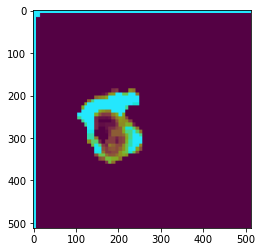

In [146]:
plt.imshow(occ_img_s)

In [18]:
result

(512, 512, 3)

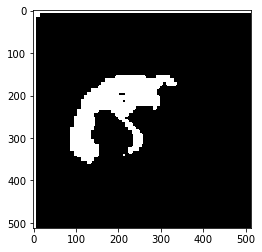

In [25]:
result = (occ_img_s > 100) * occ_img_s
result[result != 0] = 255
result = result[...,2]
plt.imshow(result, cmap="gray")

In [ ]:
cc = transforms.Compose([
    transforms.ToTensor(),
])

i = 0
with torch.no_grad():
    for image, target in zip(image_dataset, target_dataset):
        
        image = apply_ct_abdomen_filter(image)
    
        image = np.stack((image, image, image), axis=2)

        # Normalize between 0 and 1
        image = (image - image_dataset.min()) / (image_dataset.max() - image_dataset.min() + 1e-12)
        image = image.astype(np.float32)
        
        if tight_crop:
            image = image[np.ix_((image[...,0]>0).any(1), (image[...,0]>0).any(0))]
        
        image = cc(image)
        
        if device_ids:
            image = image.cuda(device_ids[0])
        image = image.unsqueeze(0)
        
        image = image.squeeze(0).permute(1,2,0).cpu().numpy()
        
        image = cc(image)
        image = image.unsqueeze(0)
        image = image.cuda()

        score, occ_maps, part_scores = model.get_occlusion(image, 0)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='', cbarmax=0)
        
        img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
        faco = img_orig.shape[0] / occ_img.shape[0]
        
        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
#         plt.figure(figsize=(8, 8))
#         plt.imshow(canvas)
#         plt.axis('off')
#         fp = f'{Directories.COMPOSITIONAL_NETS}/results/lits/train_without_occluder/test_{i}.png'
#         cv2.imwrite(fp, canvas)

In [39]:
tumor_dir = os.path.join(Directories.DATA, 'tumors')
tumors = [cv2.imread(os.path.join(tumor_dir, name)) for name in os.listdir(tumor_dir)]

In [40]:
train_hdf5_fp = os.path.join(Directories.LITS, 'train.hdf5')
with h5py.File(train_hdf5_fp, 'r') as hf:
    image_dataset = hf['images'][40:60]
    target_dataset = hf['masks'][40:60]

tumors = []
for im in image_dataset:
    im = apply_ct_abdomen_filter(im)
    
    im = np.stack((im, im, im), axis=2)

    # Normalize between 0 and 1
    im = (im - im.min()) / (im.max() - im.min())
    im = im.astype(np.float32)
    tumors.append(im)

unet_filename = 'unet_liver_2020-08-13_15:52:08.pth'
is_cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if is_cuda_available else "cpu")

path_to_unet = os.path.join(Directories.CHECKPOINTS, unet_filename)
unet = UNet(pretrained=True)
unet.load_state_dict(torch.load(path_to_unet)['model_state_dict'])
if is_cuda_available: unet.to(device)

In [ ]:
cc = transforms.Compose([
    transforms.ToTensor(),
])

i = 0
with torch.no_grad():
    for image in tumors[:10]:
        
        image = cc(image)
        
        if device_ids:
            image = image.cuda(device_ids[0])
        image = image.unsqueeze(0)
        
        out = unet(image)
        scores = F.softmax(out, dim=1)

        segmentations = torch.round(F.threshold(scores[:, 1, :, :], 0.9, 0))
        processed_images = segmentations.unsqueeze(1) * image
        
        seg_liver = processed_images.squeeze()
        image = seg_liver.unsqueeze(0)
        
        image = image.squeeze(0).permute(1,2,0).cpu().numpy()
        image = image[np.ix_((image[...,0]>0).any(1), (image[...,0]>0).any(0))]
        image = cc(image)
        image = image.unsqueeze(0)
        image = image.cuda()

        score, occ_maps, part_scores = model.get_occlusion(image, 0)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='', cbarmax=0)
        
        img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
        faco = img_orig.shape[0] / occ_img.shape[0]
        
        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        plt.figure(figsize=(8, 8))
        plt.imshow(canvas)
        plt.axis('off')
#         fp = f'{Directories.COMPOSITIONAL_NETS}/results/lits/train_without_occluder/test_{i}.png'
#         cv2.imwrite(fp, canvas)